In [1]:
%run "../../shared/utilz_image_proc.ipynb"

# 1. Test function calls

In [2]:
## Test Video capture with callback to process for identify contours on objects
def find_largest_as_doc(img_in, tfact=0.02, athresh=1000, logit=False):
    img = img_in.copy()
    if logit:
        print(f'START@find_largest_as_doc callback' )
    ## a. preprocess mask 
    img_edgez = cv2_preprocess_edges( img , dil_iterz=2)
    
    ## b. fetch contours & get largest object 
    contz, _ = cv2.findContours(img_edgez, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE )     
    max_area, biggest_obj = 0, None        
    for c in contz:
        a = cv2.contourArea( c )
        if a > athresh:
            peri = cv2.arcLength(c, True )
            appx = cv2.approxPolyDP(c, tfact*peri, True)            
            if len(appx) == 4 and a > max_area: ## is a rect and is larger
                biggest_obj = appx
                max_area = a
    
    if logit:
        print(f'@find_largest_as_doc callback --- drawing bounding box')
        
    # c. draw bounding box on identified document 
    if not biggest_obj is None:
        x, y, w, h = cv2.boundingRect( biggest_obj )
        img = cv2.rectangle( img, (x, y), (x+w, y+h), (200,0,255), 3)
    
    if logit:
        print(f'FINSHED@find_largest_as_doc callback')
    
    return img
    
cv2_video_capture( 0 , 
                  title='Tester Largest Item', 
                  img_handler=find_largest_as_doc, 
                  logit=True)

@cv2_video_capture: Starting 'Tester Largest Item' with img_handler as <function find_largest_as_doc at 0x7f0050478a70>


# 2. QRCode and BarCode Scanner
- `pyzbar` library
    - Read code message
    - Find location of code in frame

In [3]:
## Library for decoding scanner content 
from pyzbar.pyzbar import decode


In [4]:
# ip = "https://www.eurekalert.org/multimedia/pub/web/36930_web.jpg"
# img, _ = fetch_image( ip )
# plot_image(img)

In [5]:
## Example decode barcode
# ip = 
ipz = [
    "https://cdn.ttgtmedia.com/rms/misc/qr_code_barcode.jpg",
    "https://www.eurekalert.org/multimedia/pub/web/36930_web.jpg",  
    "https://arifdiyanto.files.wordpress.com/2015/11/qrcodeuk.gif", 
    "https://previews.123rf.com/images/bobnevv/bobnevv1711/bobnevv171100059/89044460-barcode-and-qr-code-set-collection-various-black-bar-codes-qr-codes-isolated-on-white-background-vec.jpg",
    "https://static2.bigstockphoto.com/9/2/3/large2/329386597.jpg",
]

qrbarcode_imagez = fetch_imagez_dict(ipz)

qrbarcode_imagez.keys()

# grid_plot_images( 
#     [ x[0] for x in qrbarcode_imagez.values()], 
#     list(qrbarcode_imagez.keys()),
#     nc=2, logit=False)

dict_keys(['Image # 0', 'Image # 1', 'Image # 2', 'Image # 3', 'Image # 4'])

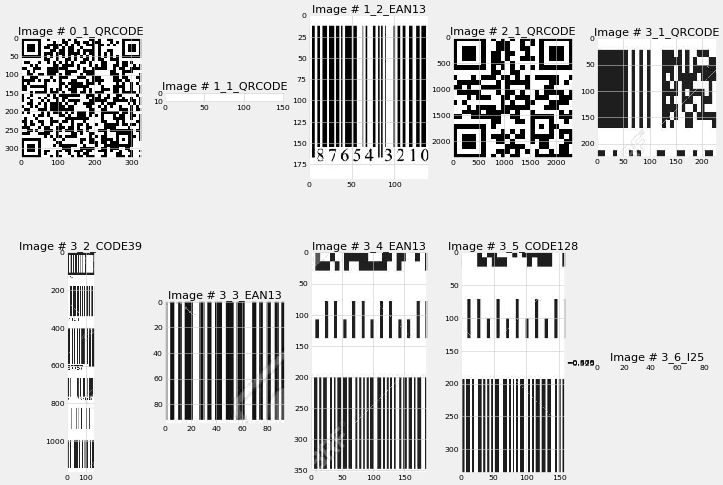

In [6]:
## Decode it << decode returns an array
findz = []
for key, img in qrbarcode_imagez.items():
    img = img[0] #cv2_preprocess_edges( img[0] )
#     findz.append( (f"{key}_prep", img) )
    for i, c in enumerate( decode(img) ):
#         print(f"<{i+1}>. {key}\n{c}" )
#         print( f"\tType: \t{c.type}")
#         print( f"\tData: \t{c.data.decode('utf-8')}")
        #print("\n")        
        x, y, w, h = c.rect
        findz.append( (f'{key}_{i+1}_{c.type}', img[x:x+w, y:y+h]) )
        
grid_plot_images(
    [bc[1] for bc in findz ], 
    [bc[0] for bc in findz ],
    nc=5, logit=False
)      

In [7]:
def handle_capture_frame(frame, logit=False):
    for qrbar in decode(frame):
#         print(qrbar)
        xi, yi, wi, hi = qrbar.rect
        xdat = qrbar.data.decode('utf-8')

        mp, bp = 20, 5
        lbl_bx_col = (20, 150, 0)
        lbl_col = (100, 10, 255)

        # box using the rect 
        frame = cv2.rectangle(
            frame, 
            (xi-bp,yi-mp-bp), (xi+wi+bp, yi+hi+bp), 
            lbl_bx_col, 2)
        # label 
        frame = cv2.rectangle(
            frame, 
            (xi-bp,yi-mp-bp), (xi+wi+bp, yi), 
            lbl_bx_col, cv2.FILLED
            )
        frame = cv2.putText(frame, 
                f'{xdat}',
               (xi, yi-bp), 
                cv2.FONT_HERSHEY_COMPLEX_SMALL, 
                0.6, lbl_col, 1) 

        #TODO: why not in this version
#         # box using the polygon << so works even on rotation of the barcode. Is better
#         poly = qrbar.get('polygon', None)
#         if poly:
#             pts = np.array( [ poly ], np.int32)
#             pts = pts.reshape( (-1, 1, 2) )
#             frame = cv2.polylines(
#                 frame, 
#                 pts,  True, 
#                 lbl_col, 3)
        
    return frame

In [8]:
src_id=0
title='QRCode/BarCode Scanner'
width=640
height=480
intensity=150
logit=False
img_handler = handle_capture_frame

# def code_scanner_capture(src_id=0, title='QRCode/BarCode Scanner', width=640, height=480, intensity=150, logit=False):    
if logit:
    print(f"@cv2_video_capture: Starting '{title}' with img_handler as {img_handler}" ) 

cap = cv2.VideoCapture( src_id ) 
cap.set(3, width) ##width is id 3
cap.set(4, height) ##height is id 4
cap.set(10, intensity)

while cap.isOpened(): ## go frame by frame
    success, frame = cap.read()
    if success:            
        ## Process = draw bounding box on barcode and put data text
        frame = img_handler(frame, logit)
        cv2.imshow( title, frame)
    if cv2.waitKey(30) & 0xFF == 27: ##ESC  # 1 == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


True

True

False

In [9]:
# code_scanner_capture(0)

# 3. OCR Grader

In [10]:
ip = "https://pyimagesearch.com/wp-content/uploads/2016/10/omr_test_01.png"
ip = "https://pyimagesearch.com/wp-content/uploads/2016/10/omr_finding_bubbles.jpg"
img, gimg = fetch_image( ip )
# grid_plot_images( [img, gimg])

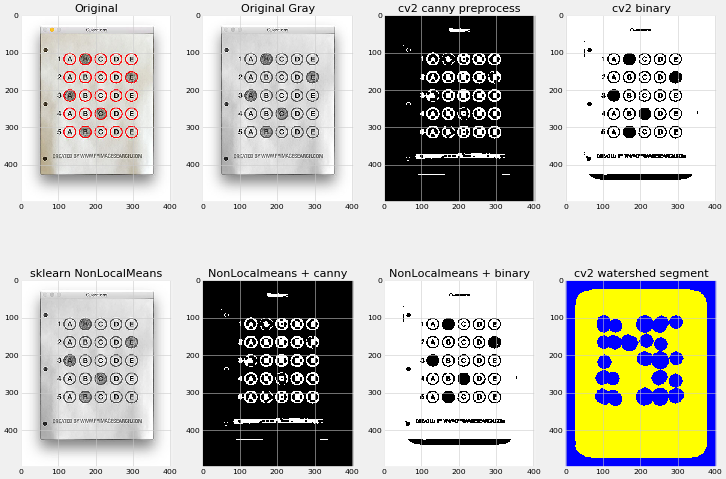

In [11]:
## resize Image
def show_preprocess_image(img, gimg):
    imagez = [img]
    labelz = ['Original']
    
    imagez.append(gimg)
    labelz.append('Original Gray')
    
    imagez.append( cv2_preprocess_edges(gimg, dil_iterz=1) )
    labelz.append( 'cv2 canny preprocess')
    
    imagez.append( clean_prepare_binary(gimg) )
    labelz.append( 'cv2 binary' )    
    
    nlm = nonlocalmeans_clean(gimg).astype(np.uint8)
    imagez.append( nlm )
    labelz.append( 'sklearn NonLocalMeans' )    
    
    imagez.append( cv2_preprocess_edges(nlm, dil_iterz=1) )
    labelz.append( 'NonLocalmeans + canny')
    
    
    imagez.append( clean_prepare_binary(nlm) )
    labelz.append( 'NonLocalmeans + binary' )
    
    _, ws = watershed_segment(img, gimg)
    imagez.append( ws )
    labelz.append( 'cv2 watershed segment' )
    watershed_segment
    
    grid_plot_images(
        imagez,
        labelz, 
        nc = 4,
        logit=False
        )
    
show_preprocess_image(img, gimg)

In [12]:
### ---- 